In [1]:
import pandas as pd
df = pd.read_csv('data/training_data.csv')
df['Category']=df['label'].replace({0:'TA',1:'Malware',2:'tool'})

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Category').Description.count().plot.bar(ylim=0)
plt.show()

<Figure size 600x400 with 1 Axes>

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df.Description).toarray()
labels = df.label
features.shape

(253, 1725)

In [4]:
from io import StringIO
col = ['Category', 'Description']
df = df[col]
df = df[pd.notnull(df['Description'])]
df.columns = ['Category', 'Description']
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.head()

,Category,Description,category_id
0,TA,G0018 admin@338 is a China-based cyber threat ...,0
1,TA,G0006 APT1 is a Chinese threat group that has ...,0
2,TA,G0005 APT12 is a threat group that has been at...,0
3,TA,G0023 APT16 is a China-based threat group that...,0
4,TA,G0025 APT17 is a China-based threat group that...,0


In [ ]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Description'], df['Category'], random_state = 0)
count_vect = CountVectorizer(min_df=5,encoding='latin-1', ngram_range=(1,2), stop_words='english')
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [33]:
df1_key=pd.DataFrame(count_vect.vocabulary_.items(),columns=['keyword','id'])
#df1_key.to_csv(r'data/vocabulary.csv',index=False)

In [34]:
df1_key.shape

(1396, 2)

In [35]:
print(clf.predict(count_vect.transform(["China-based cyber threat group. It has previously used newsworthy events as lures to deliver malware and has primarily targeted organizations involved in financial, economic, and trade policy, typically using publicly"])))

['Malware']


In [49]:
features

array([[0.06363242, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.10099212, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

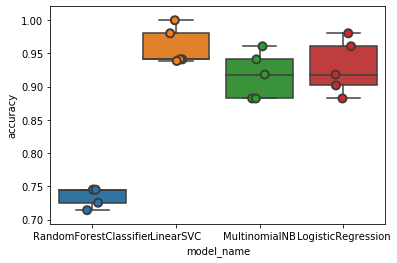

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.show()

In [21]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.960304
LogisticRegression        0.928772
MultinomialNB             0.917007
RandomForestClassifier    0.735014
Name: accuracy, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


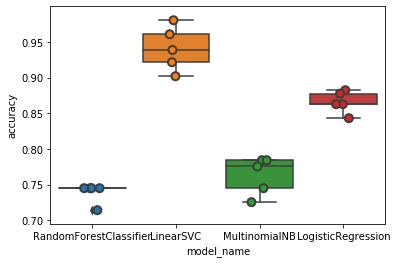

                model_name  fold_idx  accuracy
0   RandomForestClassifier         0  0.745098
1   RandomForestClassifier         1  0.745098
2   RandomForestClassifier         2  0.745098
3   RandomForestClassifier         3  0.745098
4   RandomForestClassifier         4  0.714286
5                LinearSVC         0  0.960784
6                LinearSVC         1  0.921569
7                LinearSVC         2  0.901961
8                LinearSVC         3  0.980392
9                LinearSVC         4  0.938776
10           MultinomialNB         0  0.745098
11           MultinomialNB         1  0.784314
12           MultinomialNB         2  0.725490
13           MultinomialNB         3  0.784314
14           MultinomialNB         4  0.775510
15      LogisticRegression         0  0.843137
16      LogisticRegression         1  0.882353
17      LogisticRegression         2  0.862745
18      LogisticRegression         3  0.862745
19      LogisticRegression         4  0.877551


model_name
LinearSVC                 0.940696
LogisticRegression        0.865706
MultinomialNB             0.762945
RandomForestClassifier    0.738936
Name: accuracy, dtype: float64

In [105]:
import seaborn as sns

X=df['Description']
Y=df['Category']

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer(sublinear_tf=True)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
entries=[]
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_tfidf, Y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.show()
print(cv_df)
cv_df.groupby('model_name').accuracy.mean()

0.9642857142857143


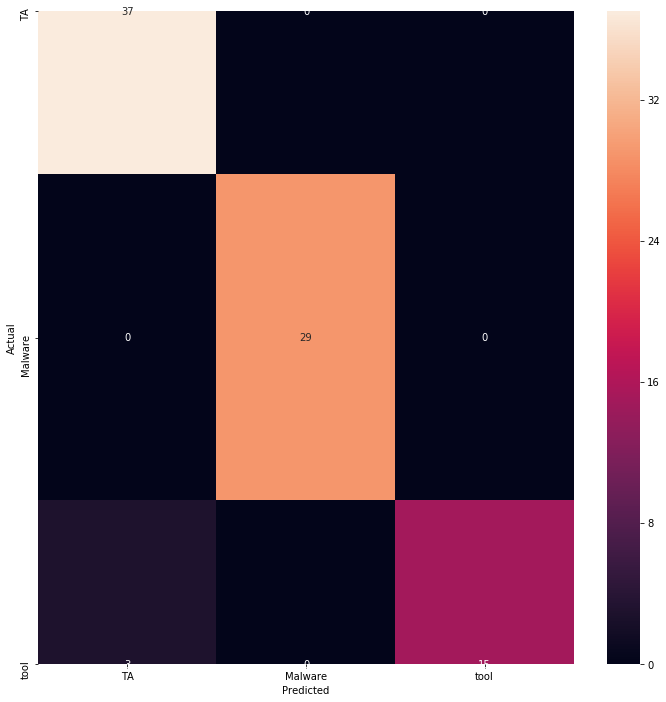

In [90]:
model = LinearSVC ()
X_train, X_test, y_train, y_test = train_test_split(df['Description'], df['Category'], test_size=0.33, random_state=0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts =  count_vect.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

model = model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,y_pred)
print(acc)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [75]:
a_test = count_vect.transform(["China-based cyber threat group. It has previously used newsworthy events as lures to deliver malware and has primarily targeted organizations involved in financial, economic, and trade policy, typically using publicly"])

In [76]:
model.predict(a_test)

array(['TA'], dtype=object)

In [70]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

              precision    recall  f1-score   support

          TA       0.93      1.00      0.96        37
     Malware       1.00      1.00      1.00        29
        tool       1.00      0.83      0.91        18

    accuracy                           0.96        84
   macro avg       0.97      0.94      0.96        84
weighted avg       0.97      0.96      0.96        84



In [47]:
import pandas as pd
import recordlinkage
keywords_ta  =pd.read_csv(r'data/threat_actor_keywords.csv')
test_df = pd.read_csv(r'data/test_sample_cleaned.csv')

In [48]:
des=[]
name=[]
for i in keywords_ta['Name'].unique():
    key = keywords_ta['keywords'][keywords_ta['Name']==i]
    try:         
        des.append(' '.join(list(key)))
        name.append(i)
    except TypeError:
        pass
keyword_df =pd.DataFrame({'name':name,'keywords':des})        

In [49]:
new=' '.join(list(test_df['keywords']))
test_df = pd.DataFrame([new],columns=['keywords'])

In [51]:
keyword_df.to_csv(r'data/concatenated_ta.csv',index=None)
test_df.to_csv(r'data/concatenated_sample_ta.csv',index=None)

In [36]:
test_df.set_index('keywords',inplace=True)

In [37]:
keyword_df.set_index('keywords',inplace=True)

In [38]:
indexer = recordlinkage.Index()
indexer.full()

<Index>

In [40]:
candidates = indexer.index(keyword_df, test_df)
print(len(candidates))

93


In [46]:
compare = recordlinkage.Compare()
compare.exact('keywords','keywords', label='keywords')
features = compare.compute(candidates, keyword_df,test_df)

KeyError: 'label is not found in the dataframe'

In [56]:
998860/2207 

452.58722247394655

In [58]:
452/60

7.533333333333333